In [1]:
import pandas as pd
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from utils import similar_proteins, c1_c2_c3
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.metrics import roc_auc_score, average_precision_score
import seaborn as sns

In [2]:
df_prot_list = pd.read_csv('../data/processed/protein_list.csv', header=None)
idx = df_prot_list[1].tolist()
idx_map = dict(zip(df_prot_list[0], df_prot_list[1]))
prot_map = dict(zip(df_prot_list[1], df_prot_list[0]))
mmseqs_file = '../data/alnRes.m8'

In [8]:
def get_pr_data(ratio, subset):
    p, r, m = np.array([]), np.array([]), np.array([])
    for model_name in ['GNN_SEQVEC', 'GNN', 'FFNN', 'DT']:
        rocs = []
        prs = []
        for cv in range(10):
            train = pd.read_csv('../data/processed/cv/'+ str(cv) + '/' + str(ratio) +'/train.csv')
            train_pos = train[train['label'] == 1].iloc[:,:2].values
            train_prots = [prot_map[x] for x in train_pos.flatten()]
            all_prots = [prot_map[x] for x in idx]
            train_nodes_sim = similar_proteins(train_prots, all_prots, mmseqs_file, seq_id = 0.4)
            train_nodes_sim = [idx_map[x] for x in train_nodes_sim]

            results = '../data/results/cv/' + str(cv) + '/' + str(ratio) + '/' + model_name + '/' + 'results.csv'
            df = pd.read_csv(results)

            isin = np.isin(df.iloc[:,:2].values, train_nodes_sim)
            isin_sum = np.sum(isin, axis=1)

            if subset == 'C1':
                c = df[isin_sum == 2]
            elif subset == 'C2':   
                c = df[isin_sum == 1]
            elif subset == 'C3':
                c = df[isin_sum == 0]
            
            if subset == 'C3' and model_name == 'DT':
                continue
                
            pred, y = c.iloc[:,3].values, c.iloc[:,2].values
            precision, recall, _ = precision_recall_curve(y, pred)
            rocs.append(roc_auc_score(y, pred))
            prs.append(average_precision_score(y, pred))
            intervals = 1001
            f = interp1d(recall, precision)
            recall_new = np.linspace(0, 1, num=intervals, endpoint=True)
            precision_new = f(recall_new)

            p = np.concatenate([p, precision_new])
            r = np.concatenate([r, recall_new])        
            m = np.concatenate([m, [model_name]*intervals])
        
        print(model_name, ratio, subset)
        print('ROC', np.mean(rocs), 2*np.std(rocs), 'PR', np.mean(prs), 2*np.std(prs))
    data = pd.DataFrame(np.array([p,r]).T).rename(columns={0:'Precision', 1:'Recall'})
    data['Model'] = m
    
    return data

In [9]:
data_c1_1 = get_pr_data(1, 'C1')
data_c2_1 = get_pr_data(1, 'C2')
data_c3_1 = get_pr_data(1, 'C3')

GNN_SEQVEC 1 C1
ROC 0.9339171291725575 0.009496428945236604 PR 0.9351653211382379 0.00967911780527463
GNN 1 C1
ROC 0.9164468046599478 0.006759343197212566 PR 0.9274516740491248 0.006087291529522149
FFNN 1 C1
ROC 0.9233339159034427 0.0027808740175700045 PR 0.9241365789797575 0.0030900302280060955
DT 1 C1
ROC 0.8929335533850953 0.0018708836823890433 PR 0.892832262435193 0.0018392174377007675
GNN_SEQVEC 1 C2
ROC 0.7060719046910637 0.012517366606159293 PR 0.710276873168823 0.02146725233736908
GNN 1 C2
ROC 0.4992110261521783 0.14075299241801942 PR 0.4759309285376935 0.09479139640725481
FFNN 1 C2
ROC 0.7980351178051885 0.01235794859393691 PR 0.7934958195399942 0.012067263766010543
DT 1 C2
ROC 0.7995642188464649 0.014147251662595554 PR 0.8141069746322923 0.010530623862267262
GNN_SEQVEC 1 C3
ROC 0.6438237232043768 0.0981743484518469 PR 0.6735171099795165 0.1125376630944276
GNN 1 C3
ROC 0.4704343967131147 0.10830594486026872 PR 0.49366585999393564 0.0732144363227192
FFNN 1 C3
ROC 0.671741628538

/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
data_c1_10 = get_pr_data(10, 'C1')
data_c2_10 = get_pr_data(10, 'C2')
data_c3_10 = get_pr_data(10, 'C3')

GNN_SEQVEC 10 C1
ROC 0.9336116395294857 0.009903223689364962 PR 0.6896155732321969 0.0427860879518872
GNN 10 C1
ROC 0.9163006543528786 0.005898412619304578 PR 0.6941952848113639 0.022607563381481524
FFNN 10 C1
ROC 0.9229138788897849 0.0031479998450595495 PR 0.6496424060806146 0.012410924211703723
DT 10 C1
ROC 0.8928788445807232 0.0019349405809718494 PR 0.5540623866768358 0.007152888672620714
GNN_SEQVEC 10 C2
ROC 0.7076829355835933 0.013991659291680208 PR 0.2381587544673506 0.03311475744407558
GNN 10 C2
ROC 0.5012247458067626 0.14252029886176215 PR 0.08665638511001424 0.030717632879092495
FFNN 10 C2
ROC 0.8012387055244978 0.011848783133599577 PR 0.3418845376737633 0.021100474313900087
DT 10 C2
ROC 0.7979865936643288 0.014385790064514401 PR 0.41589869616168357 0.01794767269470482
GNN_SEQVEC 10 C3
ROC 0.652396674842877 0.0615153579282424 PR 0.23654197952202974 0.08867249784182546
GNN 10 C3
ROC 0.4855560052884759 0.07251401287894456 PR 0.09360746858070551 0.027273666811304758
FFNN 10 C3
RO

/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
data_c1_100 = get_pr_data(100, 'C1')
data_c2_100 = get_pr_data(100, 'C2')
data_c3_100 = get_pr_data(100, 'C3')

GNN_SEQVEC 100 C1
ROC 0.9336556590234688 0.009991057825774717 PR 0.2911722957203241 0.056418107172266654
GNN 100 C1
ROC 0.9164488175907539 0.006023635841869499 PR 0.30604878813261055 0.03529351458085339
FFNN 100 C1
ROC 0.9229382950322037 0.0030090091942420053 PR 0.24848519099815447 0.014252447828866689
DT 100 C1
ROC 0.8929388579120033 0.0017286756863877603 PR 0.15880758782563087 0.0027796943883437314
GNN_SEQVEC 100 C2
ROC 0.7072924902565305 0.013392575731202509 PR 0.036623317704617006 0.009771422170869987
GNN 100 C2
ROC 0.501450988658561 0.14112292649715377 PR 0.009458356553157004 0.0035687513116672673
FFNN 100 C2
ROC 0.8003732858930499 0.01081707446139367 PR 0.06043388402051334 0.006039233342765669
DT 100 C2
ROC 0.79771105440543 0.014663214814452956 PR 0.11188412640107628 0.010135451659529232
GNN_SEQVEC 100 C3
ROC 0.6533629549442332 0.0637910005287121 PR 0.06816364805084252 0.04509627125058255
GNN 100 C3
ROC 0.49519388639120054 0.057275291337837396 PR 0.010872577300723605 0.0052141116

/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

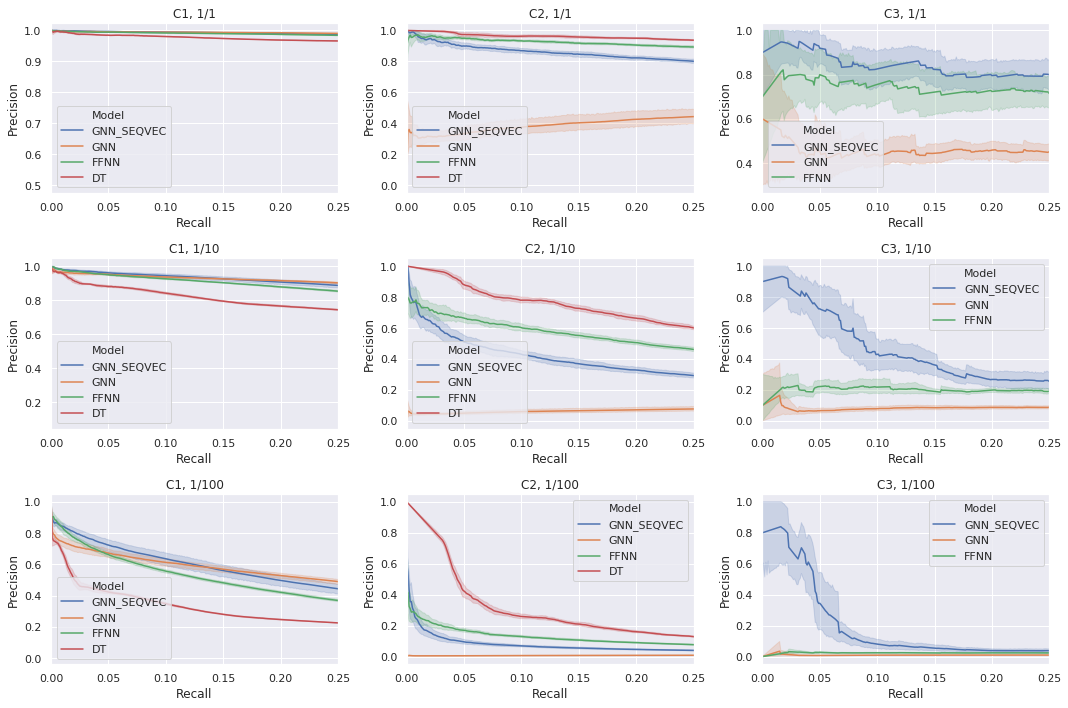

In [13]:
sns.set()
plt.tight_layout()
fig, axs = plt.subplots(3, 3, figsize=(15,10))
titles = ['C1, 1/1', 'C1, 1/10', 'C1, 1/100',\
          'C2, 1/1', 'C2, 1/10', 'C2, 1/100',\
          'C3, 1/1', 'C3, 1/10', 'C3, 1/100']

data = [data_c1_1, data_c1_10, data_c1_100,\
        data_c2_1, data_c2_10, data_c2_100,\
        data_c3_1, data_c3_10, data_c3_100,]

for i in range(3):
    for j in range(3):
        k = j*3+i
        sns.lineplot(data=data[k], x='Recall', y='Precision', hue='Model', ax=axs[i,j])
        axs[i,j].set_title(titles[k])
        axs[i,j].set_xlim(0,0.25)
        
    

fig.tight_layout()
plt.savefig('final.png')